# Predicción multiclase (SUBE, BAJA, MANTIENE) de la variación diaria de acciones a partir de:

### 1) Cotizaciones históricas de precios

### 2) Análisis de sentimiento diario (agregado por día, por expertos)

Para predecir el comportamiento de cada acción en los próximos 1 a 5 días.



## Paso 1: Cargo data sets obtenidos desde base de datos (Scrapping)

In [154]:
import pandas as pd

# Reemplazá el nombre del archivo por la ruta correcta si no está en el mismo directorio
acciones_df = pd.read_csv("cotizacion_x_empresa.csv")
sentimientos_df = pd.read_csv("view_variacion_x_noticias.csv")
empresas_df = pd.read_csv("empresas.csv")
llm_df = pd.read_csv("notas_x_usuario_openai.csv")
llm_df = llm_df[llm_df['relevante_economia'] == 1].copy()

# Ver las primeras filas para verificar que se cargó correctamente
print(acciones_df.head())
print(sentimientos_df.head())
print(empresas_df.head())

# Ver información básica de los DataFrames (columnas, tipos, nulos)
print(sentimientos_df.info())
print(empresas_df.info())
print(llm_df.info())

# Agrega la columna 'empresa' con un valor predeterminado
acciones_df['nombre'] = 'NNNN'  # Reemplaza 'Valor predeterminado' con el valor que desees
print(acciones_df.info())


   id_cotizacion  id_empresa                fecha  precio_apertura  \
0            658          10  2023-01-02 03:00:00            13.05   
1            659          10  2023-01-03 03:00:00            13.50   
2            660          10  2023-01-04 03:00:00            13.20   
3            661          10  2023-01-05 03:00:00            13.00   
4            662          10  2023-01-06 03:00:00            12.95   

   precio_cierre  precio_max  precio_min  volumen_operado variacion_porcentaje  
0          13.50       13.50       13.05          9563.95                  NAN  
1          13.20       13.50       12.55         38148.80    -2.22222222222222  
2          12.90       13.35       12.80         13887.00    -2.27272727272726  
3          13.15       13.15       12.90         24053.30     1.93798449612403  
4          13.30       13.30       12.80         44834.15     1.14068441064639  
  nombre_empresa     fecha_cotizacion  variacion_total_cotizacion  \
0          AAPLD  2023-0

In [155]:
# Notas po0r usuarios y agrego id_nota
notas_df = pd.read_csv("notas_x_usuario.csv")
notas_df['fecha_publicacion'] = pd.to_datetime(notas_df['fecha_publicacion'], format='mixed')
notas_df['fecha'] = notas_df['fecha_publicacion'].dt.date 



llm_df = llm_df.merge(
    notas_df[['id_nota', 'fecha_publicacion']],
    on='id_nota',
    how='left'
)

print(notas_df.info())
print(llm_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48491 entries, 0 to 48490
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id_nota                         48491 non-null  int64         
 1   contenido                       48412 non-null  object        
 2   fecha_publicacion               48491 non-null  datetime64[ns]
 3   id_usuario                      48491 non-null  object        
 4   cod_tipo_nota                   48491 non-null  int64         
 5   url_nota                        48491 non-null  object        
 6   engagement_total                48491 non-null  int64         
 7   score_analisis_sentimiento_nlp  0 non-null      float64       
 8   sentimiento                     48491 non-null  object        
 9   score_sentimiento               48491 non-null  float64       
 10  fecha                           48491 non-null  object        
dtypes:

## Paso 2: Agrego el nombre de empresa al data frame de cotizaciones históricas.

Esto lo hacemos usando la relación del campo "empresa_id" del data frame "empresa_df".

In [156]:
# Hacemos un merge usando la columna 'id_empresa' que existe en ambos DataFrames
acciones_df = acciones_df.merge(
    empresas_df[['id_empresa', 'nombre']],  # Solo traemos la columna que necesitamos
    on='id_empresa',
    how='left'  # Para mantener todas las filas originales de acciones_df
)


# Verificamos que se haya agregado correctamente
print(acciones_df[['id_empresa', 'nombre']].head())

# merge de sentimientos LLM
llm_df['fecha_publicacion'] = pd.to_datetime(llm_df['fecha_publicacion'])
llm_df['fecha_publicacion'] = llm_df['fecha_publicacion'].dt.date 
sentimientos_df['fecha_cotizacion'] = pd.to_datetime(sentimientos_df['fecha_cotizacion'])
sentimientos_df['fecha_cotizacion'] = sentimientos_df['fecha_cotizacion'].dt.date 


# Elegimos la valoracion_llm más frecuente por día
valoracion_por_fecha = (
    llm_df.groupby('fecha_publicacion')['valoracion_llm']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
    .reset_index()
)

sentimientos_df = sentimientos_df.merge(
    valoracion_por_fecha,
    left_on='fecha_cotizacion',
    right_on='fecha_publicacion',
    how='left'
)

# (opcional) eliminar la columna 'fecha_publicacion' duplicada si ya no se necesita
# sentimientos_df.drop(columns='fecha_publicacion', inplace=True)


KeyError: "['nombre'] not in index"

In [127]:
print(sentimientos_df.tail())

     nombre_empresa fecha_cotizacion  variacion_total_cotizacion  \
5099           XOMD       2025-04-24                       -0.05   
5100           XOMD       2025-04-25                        0.00   
5101           XOMD       2025-04-28                        0.10   
5102           XOMD       2025-04-29                       -0.20   
5103           XOMD       2025-04-30                       -0.05   

      total_noticias_negativas  suma_score_sentimiento_negativas  \
5099                       118                          -62.0434   
5100                       118                          -60.9628   
5101                       100                          -44.8269   
5102                        99                          -44.6587   
5103                        97                          -46.3100   

      total_noticias_positivas  suma_score_sentimiento_positivas  \
5099                        91                           41.9033   
5100                        72                

## Paso 3: Etiquetamos en el data frame de cotizaciones histórcas el target para el modelo.

Creamos la columna de etiqueta (label) con las tres clases (SUBE, BAJA, MANTIENE) de forma muy simple.

In [ ]:
# Función que agrega la etiqueta a predecir
def etiquetar(variacion):
    if variacion > 0:
        return "SUBE"
    elif variacion < 0:
        return "BAJA"
    else:
        return "MANTIENE"

# Antes de aplicar la función etiquetar, asegurate de que los valores en "variacion_porcentaje" sean numéricos.
acciones_df['variacion_porcentaje'] = pd.to_numeric(
    acciones_df['variacion_porcentaje'], errors='coerce'
)

acciones_df['label'] = acciones_df['variacion_porcentaje'].apply(etiquetar)

print(acciones_df.head(200))

     id_cotizacion  id_empresa                fecha  precio_apertura  \
0              658          10  2023-01-02 03:00:00            13.05   
1              659          10  2023-01-03 03:00:00            13.50   
2              660          10  2023-01-04 03:00:00            13.20   
3              661          10  2023-01-05 03:00:00            13.00   
4              662          10  2023-01-06 03:00:00            12.95   
..             ...         ...                  ...              ...   
195            853          10  2023-10-19 03:00:00            18.90   
196            854          10  2023-10-20 03:00:00            18.70   
197            855          10  2023-10-23 03:00:00            19.00   
198            856          10  2023-10-24 03:00:00            17.95   
199            857          10  2023-10-25 03:00:00            18.10   

     precio_cierre  precio_max  precio_min  volumen_operado  \
0            13.50       13.50       13.05          9563.95   
1        

## Paso 4: Merge de dtos de acciones y análisis de sentimiento.

Este nuevo data set será el que usaremos para input del modelo.

In [139]:
# Renombrar columnas en sentimientos_df para facilitar el merge
sentimientos_df = sentimientos_df.rename(columns={
    'nombre_empresa': 'nombre',
    'fecha_cotizacion': 'fecha'
})

# Asegurarse de que las fechas estén en formato datetime
acciones_df['fecha'] = pd.to_datetime(acciones_df['fecha'])
sentimientos_df['fecha'] = pd.to_datetime(sentimientos_df['fecha'])

# Hacer el merge
analisis_df = acciones_df.merge(
    sentimientos_df,
    on=['nombre', 'fecha'],
    how='inner'  # o 'inner' si solo querés mantener las coincidencias
)

# Elimino columnas que no usaré
# Supongamos que quieres eliminar las columnas 'columna1' y 'columna2'
columnas_a_eliminar = ['nombre_x', 'nombre_y']
analisis_df = analisis_df.drop(columns=columnas_a_eliminar)


# Verificación
print(analisis_df.head())
print(analisis_df.info())


Empty DataFrame
Columns: [id_cotizacion, id_empresa, fecha, precio_apertura, precio_cierre, precio_max, precio_min, volumen_operado, variacion_porcentaje, nombre, label, variacion_total_cotizacion, total_noticias_negativas, suma_score_sentimiento_negativas, total_noticias_positivas, suma_score_sentimiento_positivas, fecha_publicacion, valoracion_llm]
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id_cotizacion                     0 non-null      int64         
 1   id_empresa                        0 non-null      int64         
 2   fecha                             0 non-null      datetime64[ns]
 3   precio_apertura                   0 non-null      float64       
 4   precio_cierre                     0 non-null      float64       
 5   precio_max                        0 non-null     

## Paso 5: Feature Engineering:

- Variables que vamos a transformar.
- Código para aplicar lag, rolling mean y rolling std
- Relaciones de sentimiento
- Eliminar filas con NaN por lags o rolling


In [ ]:
def rolling_ticker (group, window=5):
    # construye X = [[0],[1],…,[w-1]] para el regresor
    X = np.arange(window).reshape(-1,1)
    lr = LinearRegression()
    slopes = [np.nan] * (window-1)  # no hay pendiente antes de llenar la ventana

    for i in range(window, len(group)+1):
        y = group['precio_cierre'].values[i-window:i].reshape(-1,1)
        lr.fit(X, y)
        slopes.append(lr.coef_[0][0])
    return pd.Series(slopes, index=group.index)




In [157]:
# Asegurarse del tipo datetime
analisis_df['fecha'] = pd.to_datetime(analisis_df['fecha'])

# Ordenar por empresa y fecha
analisis_df = analisis_df.sort_values(by=['id_empresa', 'fecha']).copy()

# ----------------------------------------
# 1. Features derivados de la fecha
# ----------------------------------------
analisis_df['anio'] = analisis_df['fecha'].dt.year
analisis_df['mes'] = analisis_df['fecha'].dt.month
analisis_df['dia'] = analisis_df['fecha'].dt.day
analisis_df['dia_semana'] = analisis_df['fecha'].dt.weekday  # 0 = lunes
analisis_df['es_fin_de_mes'] = analisis_df['fecha'].dt.is_month_end.astype(int)

# ----------------------------------------
# 2. Lags de variables clave (1 día atrás)
# ----------------------------------------
lag_features = [
    'variacion_porcentaje',
    'precio_cierre',
    'volumen_operado',
    'suma_score_sentimiento_positivas',
    'suma_score_sentimiento_negativas',
    'total_noticias_positivas',
    'total_noticias_negativas'
]

for col in lag_features:
    for lag in [1, 2, 3]:
        analisis_df[f'{col}_lag_{lag}'] = analisis_df.groupby('id_empresa')[col].shift(lag)

# ----------------------------------------
# 3. Medias móviles y std (ventanas de 3 y 5 días)
# ----------------------------------------
rolling_features = [
    'variacion_porcentaje',
    'precio_cierre',
    'volumen_operado',
    'suma_score_sentimiento_positivas',
    'suma_score_sentimiento_negativas',
    'total_noticias_positivas',
    'total_noticias_negativas'
]

for col in rolling_features:
    analisis_df[f'{col}_media_3d'] = analisis_df.groupby('id_empresa')[col].transform(lambda x: x.rolling(window=3).mean())
    analisis_df[f'{col}_std_3d'] = analisis_df.groupby('id_empresa')[col].transform(lambda x: x.rolling(window=3).std())
    
    analisis_df[f'{col}_media_5d'] = analisis_df.groupby('id_empresa')[col].transform(lambda x: x.rolling(window=5).mean())
    analisis_df[f'{col}_std_5d'] = analisis_df.groupby('id_empresa')[col].transform(lambda x: x.rolling(window=5).std())

# ----------------------------------------
# 4. Ratios y diferencias
# ----------------------------------------
analisis_df['ratio_sent_positivo_negativo'] = (
    analisis_df['suma_score_sentimiento_positivas'] / 
    (analisis_df['suma_score_sentimiento_negativas'] + 1e-6)
)

analisis_df['diff_score_sentimiento'] = (
    analisis_df['suma_score_sentimiento_positivas'] -
    analisis_df['suma_score_sentimiento_negativas']
)

# ----------------------------------------
# 5. Tendencias
# ----------------------------------------
import numpy as np
from sklearn.linear_model import LinearRegression
windows = 5
analisis_df['slope_5d'] = analisis_df.groupby('nombre').apply(lambda g: rolling_ticker(g, window=5)).droplevel(0);


# ----------------------------------------
# 6. Limpieza: eliminar filas con NaNs generados por lags/rolling
# ----------------------------------------
analisis_df = analisis_df.dropna(subset=[col for col in analisis_df.columns if 'lag_' in col or 'media_' in col or 'std_' in col])

# ----------------------------------------
# 6. Limpieza: eliminar filas con NaNs generados por lags/rolling
# ----------------------------------------
analisis_df = analisis_df.dropna(subset=[col for col in analisis_df.columns if 'lag_' in col or 'media_' in col or 'std_' in col])

print(analisis_df.info())

ValueError: Cannot remove 1 levels from an index with 1 levels: at least one level must be left.

## Paso 6: Preparación para modelado

- Definir la variable objetivo (y).
- Seleccionar variables predictoras (X)


In [45]:
# Excluir columnas que no queremos en X
columnas_excluir = [
    'id_cotizacion', 'id_empresa', 'fecha', 'nombre', 'label'
]

# Crear X con todas las columnas numéricas excepto las excluidas
X = analisis_df.drop(columns=columnas_excluir)
y = analisis_df['label']

# Verificamos el shape
print(f"Shape X: {X.shape}")
print(f"Shape y: {y.shape}")



Shape X: (2709, 62)
Shape y: (2709,)
<bound method DataFrame.info of       precio_apertura  precio_cierre  precio_max  precio_min  volumen_operado  \
0               19.40          19.30       19.50       19.05         75013.05   
1               19.30          19.40       19.40       19.15         74513.10   
2               19.50          19.30       19.50       18.75        102403.50   
3               19.50          19.10       19.50       18.85        194823.25   
4               19.20          19.85       19.90       19.10        164317.25   
...               ...            ...         ...         ...              ...   
2704            10.30          10.15       10.40       10.00         12994.30   
2705            10.40          10.10       10.40        9.98          3507.05   
2706            10.55          10.60       10.65       10.50          4504.75   
2707            10.70          10.50       10.75       10.45         13336.85   
2708            10.95          10.90    

## Paso 7: Separar analisis_df en conjuntos de entrenamiento, validación y test manteniendo el orden temporal.

### Proporción sugerida:

- Entrenamiento: 70%
- Validación: 15%
- Test (evaluación final): 15%

### Consideraciones:

- Vamos a ordenar por id_empresa y fecha.
- Vamos a hacer el split por fecha, no aleatoriamente.
- Vamos a usar label como variable objetivo.

In [67]:
# Ordenar por empresa y fecha (por si acaso)
analisis_df = analisis_df.sort_values(by=['id_empresa', 'fecha']).reset_index(drop=True)

# Opcional: codificar la variable objetivo si el modelo lo requiere
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
analisis_df['label_encoded'] = le.fit_transform(analisis_df['label'])

# Obtener el índice de corte basado en proporciones
n_total = len(analisis_df)
train_size = int(n_total * 0.7)
val_size = int(n_total * 0.15)

# Separar por índices (respetando el orden temporal)
train_df = analisis_df.iloc[:train_size]
val_df = analisis_df.iloc[train_size:train_size + val_size]
test_df = analisis_df.iloc[train_size + val_size:]

# Separar features y target
feature_cols = [col for col in analisis_df.columns 
                if col not in ['label', 'label_encoded', 'fecha', 'nombre', 'id_cotizacion']]

X_train, y_train = train_df[feature_cols], train_df['label_encoded']
X_val, y_val     = val_df[feature_cols], val_df['label_encoded']
X_test, y_test   = test_df[feature_cols], test_df['label_encoded']

# Confirmación
print(f"Train shape: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")


Train shape: (1871, 68), Validation: (400, 68), Test: (402, 68)


In [71]:
# Instalamos libería Autogluon
!pip install autogluon

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
  Using cached alembic-1.15.2-py3-none-any.whl.metadata (7.3 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.12.3 requires botocore<1.34.70,>=1.34.41, but you have botocore 1.38.7 which is incompatible.
autoviz 0.1.905 requires xgboost<1.7,>=0.82, but you have xgboost 3.0.0 which is incompatible.
ydata-profiling 4.16.1 requires visions[type_image_path]<0.8.2,>=0.7.5, but you have visions 0.7.4 which is incompatible.


In [79]:
from autogluon.tabular import TabularPredictor

# Concatenar los conjuntos de entrenamiento y validación para el entrenamiento
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

# Agregar la columna objetivo al DataFrame
train_data = X_train_val.copy()
train_data['label'] = y_train_val

# Inicializar y entrenar el predictor
predictor = TabularPredictor(label='label', problem_type='multiclass').fit(train_data)

# Evaluar el modelo en el conjunto de prueba
performance = predictor.evaluate(X_test.assign(label=y_test))
print(performance)


No path specified. Models will be saved in: "AutogluonModels\ag-20250502_190901"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.3.0
Python Version:     3.12.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          14
Memory Avail:       1.77 GB / 15.31 GB (11.6%)
Disk Space Avail:   286.86 GB / 475.95 GB (60.3%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'       

{'accuracy': 1.0, 'balanced_accuracy': 1.0, 'mcc': 1.0}


## Paso 8: Evaluando la performance

In [75]:
performance = predictor.evaluate(X_test.assign(label=y_test))
print(performance)


{'accuracy': 1.0, 'balanced_accuracy': 1.0, 'mcc': 1.0}


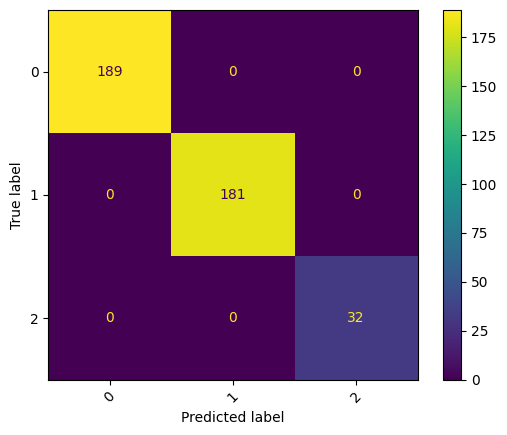

In [76]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predecimos las etiquetas en el test
y_pred = predictor.predict(X_test)

# Mostrar la matriz
cm = confusion_matrix(y_test, y_pred, labels=y_test.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=predictor.class_labels)
disp.plot(xticks_rotation=45)


In [77]:
predictor.feature_importance(X_test)


ValueError: Provided DataFrame does not contain label column: label